## Download ENTEx experiments and extract files to download

In [8]:
import importlib
import pandas as pd
from pathlib import Path
from collections import Counter

import brew_omics
importlib.reload(brew_omics)

# Really only experiments are needed for ENTEx and others are obtained from ENCODE folder
init_experiments, init_experiments_path = brew_omics.fetch_encode_metadata(
    "data/entex/init_experiments.pkl",
    "https://www.encodeproject.org/report.tsv?type=Experiment&status=released&internal_tags=ENTEx&limit=all",
    check_ids=['ID'], skip_rows=1, sep='\t', data_type='Experiment', overwrite=False)

# report_sam, report_sam_path = brew_omics.fetch_encode_metadata(
#     "data/entex/report_sam.pkl",
#     "https://www.encodeproject.org/report.tsv?type=Biosample&status=released&internal_tags=ENTEx&limit=all",
#     check_ids=['Accession'], skip_rows=1, sep='\t', data_type='Biosample', overwrite=False)

# metadata_file, metadata_file_path = brew_omics.fetch_encode_metadata(
#     "data/entex/metadata_file.pkl",
#     "https://www.encodeproject.org/metadata/?type=Experiment&status=released&internal_tags=ENTEx&limit=all",
#     check_ids=['File accession'], skip_rows=0, sep='\t', data_type='File', overwrite=False)

# Somehow this failed, probably internal_tags does not work for type=File
# report_file, report_file_path = brew_omics.fetch_encode_metadata(
#     "data/entex/report_file.pkl",
#     "https://www.encodeproject.org/report.tsv?type=File&status=released&internal_tags=ENTEx&limit=all",
#     check_ids=['ID', 'Dataset'],
#     skip_rows=1, sep='\t',
#     data_type='File')

Loaded cached ENCODE Experiment metadata with shape: (1586, 40)
    column 'ID': experiments = 1586


In [9]:
# Get the master file report with biosample information
encode_files_samples = pd.read_pickle("data/encode/init_files_samples.pkl")
encode_files_samples.set_index('Accession', inplace=True, drop=False)
encode_files_samples.index.name = 'Index'
encode_file_accs = set(encode_files_samples['Accession'].tolist())

# column "Files" in report_expt contains list of file ids, separated by commas
entex_file_accs = []
for file_list in init_experiments['Files'].dropna():
    entex_file_accs.extend([f.strip('/').split('/')[-1] for f in file_list.split(',')])

print(f"A total of file accessions found in experiments: {len(entex_file_accs)}")
print(entex_file_accs[:5])

files_not_found = [f for f in entex_file_accs if f not in encode_file_accs]
if len(files_not_found) == 0:
    print("All files in experiments are present in encode_files_samples.")
else:
    print(f"Missing files in encode_files_samples: {files_not_found}")

# Extract the rows in report_file_biosample corresponding to the file_accessions
init_files_samples = encode_files_samples.loc[entex_file_accs]
print(f"Extracted ENTex files_samples shape: {init_files_samples.shape}")

# Save the extracted report_file_biosample_entex
init_files_samples.to_pickle("data/entex/init_files_samples.pkl")
init_files_samples.to_csv("data/entex/init_files_samples.csv", index=False)
print("Saved extracted init_files_samples to data/entex/init_files_samples.pkl/csv")

final_files_samples = init_files_samples[init_files_samples['Biosample accession'].notna()]
print(f"final_files_samples shape: {final_files_samples.shape}")
final_files_samples.to_pickle("data/entex/final_files_samples.pkl")
final_files_samples.to_csv("data/entex/final_files_samples.csv", index=False)
print("Saved final_files_samples to data/entex/final_files_samples.pkl/csv")

A total of file accessions found in experiments: 37291
['ENCFF854PQD', 'ENCFF851TIV', 'ENCFF565HBG', 'ENCFF542ZZT', 'ENCFF064KQN']
All files in experiments are present in encode_files_samples.
Extracted ENTex files_samples shape: (37291, 89)
Saved extracted init_files_samples to data/entex/init_files_samples.pkl/csv
final_files_samples shape: (5462, 89)
Saved final_files_samples to data/entex/final_files_samples.pkl/csv


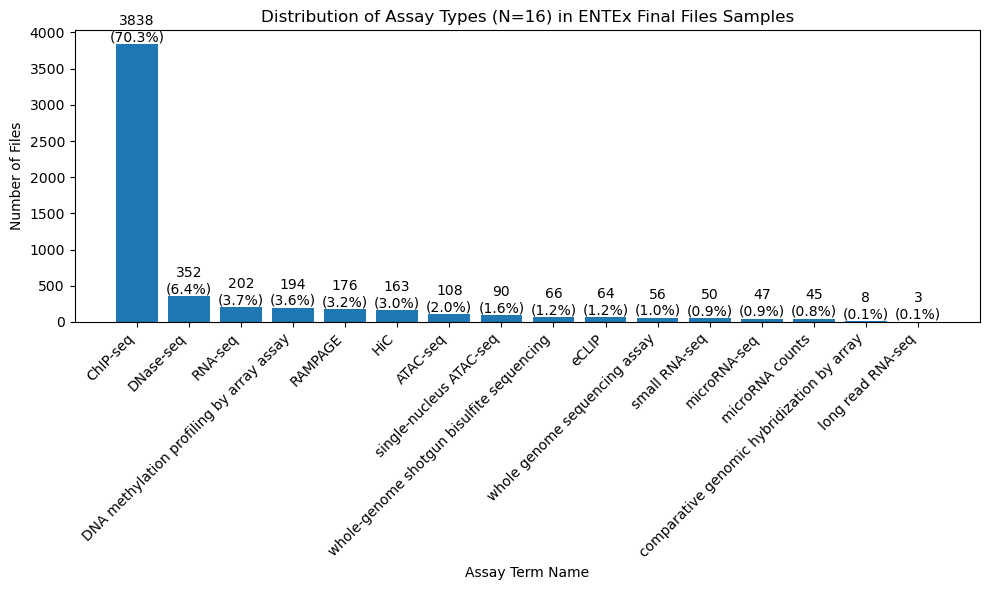

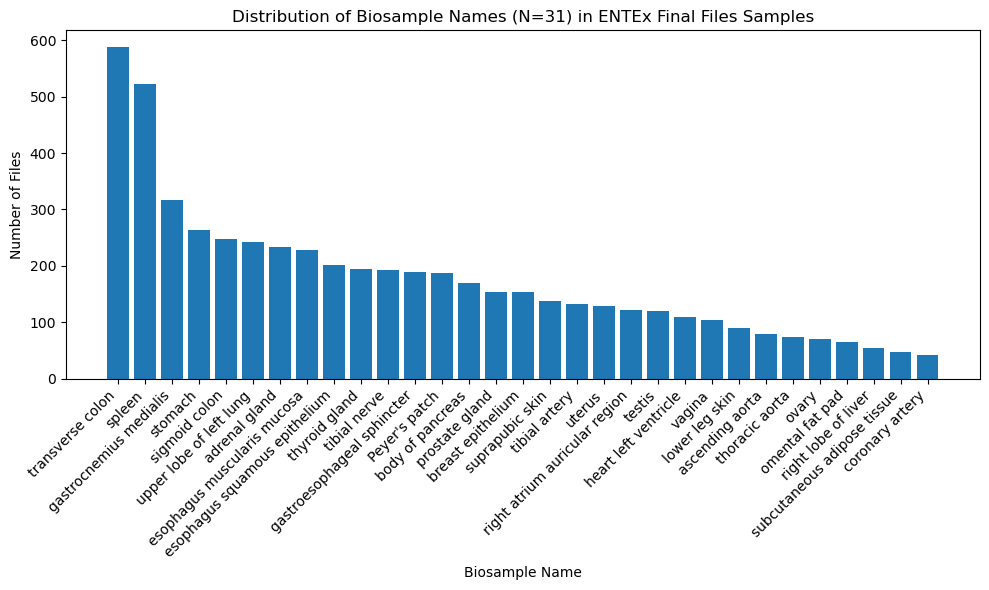

In [25]:
# import gwplot
# gwplot.ply_dfs_xy(final_files_samples, y='Assay term name', fmt='countstackedbar',
#     title='ENTEx final files samples by Organ and Assay term name',
#     plot_width=900, plot_height=600,
#     margin_r=300,
#     outfile="data/entex/plots/entex_final_files_samples_by_organ_assay_term_name.html")

# import glance_df
# gdf = glance_df.MyDataFrame(final_files_samples)
# gdf.plx_xys(x='Assay term name', fmt='pie',)

# Use matplotlib to plot the distribution of assay types
import matplotlib.pyplot as plt
assay_counts = Counter(final_files_samples['Assay term name'])
assay_names = list(assay_counts.keys())
assay_values = [assay_counts[name] for name in assay_names]
# sort by values
assay_names, assay_values = zip(*sorted(zip(assay_names, assay_values), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
plt.bar(assay_names, assay_values)
# show the percentages on top of bars
total = sum(assay_values)
for i, v in enumerate(assay_values):
    plt.text(i, v + 1, f"{v}\n({v/total:.1%})", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Assay Term Name')
plt.ylabel('Number of Files')
plt.title(f'Distribution of Assay Types (N={len(assay_names)}) in ENTEx Final Files Samples')
plt.tight_layout()
# plt.savefig("data/entex/plots/entex_final_files_samples_assay_term_name_distribution.png")
plt.show()

# show the distrubtion of "Biosample name"
biosample_counts = Counter(final_files_samples['Biosample name'])
biosample_names = list(biosample_counts.keys())
biosample_values = [biosample_counts[name] for name in biosample_names]
# sort by values
biosample_names, biosample_values = zip(*sorted(zip(biosample_names, biosample_values), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
plt.bar(biosample_names, biosample_values)
# # show the percentages on top of bars
# total = sum(biosample_values)
# for i, v in enumerate(biosample_values):
#     plt.text(i, v + 1, f"{v}\n({v/total:.1%})", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Biosample Name')
plt.ylabel('Number of Files')
plt.title(f'Distribution of Biosample Names (N={len(biosample_names)}) in ENTEx Final Files Samples')
plt.tight_layout()
# plt.savefig("data/entex/plots/entex_final_files_samples_biosample_name_distribution.png")
plt.show()

In [10]:
init_samples_merged = pd.read_pickle("data/encode/init_samples_merged.pkl")
print(f"Loaded ENCODE biosample data with shape: {init_samples_merged.shape}")
init_samples_merged.set_index('Accession', inplace=True, drop=False)
init_samples_merged.index.name = 'Index'

final_samples_accs = final_files_samples['Biosample accession'].unique().tolist()
print(f"Number of unique biosample accessions in interim_files_samples: {len(final_samples_accs)}")

# Get the list of biosample accessions from interim_files_samples
final_samples = init_samples_merged[init_samples_merged['Accession'].isin(final_samples_accs)]
# final_samples.to_pickle("data/entex/final_samples.pkl")
final_samples.to_csv("data/entex/final_samples.csv", index=False)
print("Saved final filtered biosample data to data/entex/final_samples.pkl/csv")

Loaded ENCODE biosample data with shape: (29934, 34)
Number of unique biosample accessions in interim_files_samples: 669
Saved final filtered biosample data to data/entex/final_samples.pkl/csv


In [ ]:
import importlib
importlib.reload(brew_omics)
importlib.reload(brew_omics.gwio)

assay_column = 'Assay term name' # 'Assay title' has 'RNA-seq' as "total RNA-seq"
assay_file_types = {
    'RNA-seq': ['fastq',],
    'DNase-seq': ['fastq',],
}

groupby = 'Biosample accession'
groupby = 'Organ'
groupby = 'Biosample name'  # this gives the same tissue list on ENTEx website table
download_path = Path(f"data/entex/downloads_sample_name")

final_groups = final_files_samples.groupby(groupby)

init_files_samples.set_index('Accession', inplace=True, drop=False)
init_files_samples.index.name = 'Index'
files_by_dataset = init_files_samples.groupby('Dataset')

download_report = brew_omics.download_encode_files_by_groups(
    init_files_samples, # The master metata is needed to find other files (e.g., bam, bigwig) from the same samples
    groupby, assay_file_types, download_path,
    assay_column=assay_column,
    files_groups=final_groups,
    files_by_dataset=files_by_dataset,
    check_same_sample=(groupby.lower() == 'biosample accession'),
    download_now=False,
)

print(f"Downloaded a total of {len(download_report)} files for selected biosamples and assay types.")
final_files_downloads = pd.merge(init_files_samples, download_report, on='Accession', how='inner')
final_files_downloads.to_pickle("data/entex/final_files_downloads.pkl")
final_files_downloads.to_csv("data/entex/final_files_downloads.csv", index=False)
print("Saved final downloaded files metadata to data/entex/final_files_downloads.pkl/csv")

Biosample name:  10%|▉         | 3/31 [00:00<00:00, 28.67it/s]

Biosample name: Peyer's patch; saved metadata to data/entex/downloads_sample_name/Peyer-s-patch.csv
    Assay: RNA-seq, Datasets: ['/experiments/ENCSR544SAU/', '/experiments/ENCSR257NIR/', '/experiments/ENCSR450BNZ/', '/experiments/ENCSR802HPM/']
    Dataset /experiments/ENCSR544SAU/ has 27 files.
    File accession: ENCFF891NXQ
    File accession: ENCFF667RSP
    Dataset /experiments/ENCSR257NIR/ has 27 files.
    File accession: ENCFF896HPA
    File accession: ENCFF404WDI
    Dataset /experiments/ENCSR450BNZ/ has 27 files.
    File accession: ENCFF914PVR
    File accession: ENCFF802JGP
    Dataset /experiments/ENCSR802HPM/ has 27 files.
    File accession: ENCFF294NNJ
    File accession: ENCFF283QEY
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR261RWJ/', '/experiments/ENCSR455GUW/', '/experiments/ENCSR689DSM/', '/experiments/ENCSR954AJK/']
    Dataset /experiments/ENCSR261RWJ/ has 38 files.
    File accession: ENCFF438IKT
        File data/entex/downloads_sample_name/Peyer-s-pa

Biosample name:  39%|███▊      | 12/31 [00:00<00:00, 37.57it/s]

    Assay: DNase-seq, Datasets: ['/experiments/ENCSR783OCW/']
    Dataset /experiments/ENCSR783OCW/ has 42 files.
    File accession: ENCFF077DYY
        File data/entex/downloads_sample_name/esophagus-squamous-epithelium/DNase-seq/ENCFF077DYY.fastq.gz already exists, skipping download.
    File accession: ENCFF369GXC
        File data/entex/downloads_sample_name/esophagus-squamous-epithelium/DNase-seq/ENCFF369GXC.fastq.gz already exists, skipping download.
    File accession: ENCFF429JTA
        File data/entex/downloads_sample_name/esophagus-squamous-epithelium/DNase-seq/ENCFF429JTA.fastq.gz already exists, skipping download.
    File accession: ENCFF586YGB
        File data/entex/downloads_sample_name/esophagus-squamous-epithelium/DNase-seq/ENCFF586YGB.fastq.gz already exists, skipping download.
    File accession: ENCFF112YGS
        File data/entex/downloads_sample_name/esophagus-squamous-epithelium/DNase-seq/ENCFF112YGS.fastq.gz already exists, skipping download.
    File accessi

Biosample name:  74%|███████▍  | 23/31 [00:00<00:00, 42.45it/s]

    File accession: ENCFF678UYJ
    Dataset /experiments/ENCSR827IXS/ has 27 files.
    File accession: ENCFF658BPQ
    File accession: ENCFF064HEH
    Dataset /experiments/ENCSR812AKX/ has 27 files.
    File accession: ENCFF326CGI
    File accession: ENCFF663VCC
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR276ITP/', '/experiments/ENCSR391YAV/', '/experiments/ENCSR462XTM/']
    Dataset /experiments/ENCSR276ITP/ has 44 files.
    File accession: ENCFF255JSR
    File accession: ENCFF270DKA
    File accession: ENCFF059PYS
    File accession: ENCFF683OIU
    Dataset /experiments/ENCSR391YAV/ has 42 files.
    File accession: ENCFF380IZN
    File accession: ENCFF459VFQ
    File accession: ENCFF523XNG
    File accession: ENCFF610BDZ
    File accession: ENCFF056MPO
    File accession: ENCFF791RMH
    Dataset /experiments/ENCSR462XTM/ has 40 files.
    File accession: ENCFF333LUA
    File accession: ENCFF167BPY
    File accession: ENCFF529LCT
    File accession: ENCFF876BHL
Biosample na

Biosample name: 100%|██████████| 31/31 [00:00<00:00, 39.84it/s]

Biosample name: tibial nerve; saved metadata to data/entex/downloads_sample_name/tibial-nerve.csv
    Assay: RNA-seq, Datasets: ['/experiments/ENCSR796HLX/', '/experiments/ENCSR648OSR/', '/experiments/ENCSR272UNO/', '/experiments/ENCSR858QEL/']
    Dataset /experiments/ENCSR796HLX/ has 27 files.
    File accession: ENCFF534AYT
    File accession: ENCFF935LBC
    Dataset /experiments/ENCSR648OSR/ has 27 files.
    File accession: ENCFF500BAC
    File accession: ENCFF672VNI
    Dataset /experiments/ENCSR272UNO/ has 27 files.
    File accession: ENCFF640ENZ
    File accession: ENCFF775AKZ
    Dataset /experiments/ENCSR858QEL/ has 27 files.
    File accession: ENCFF760KXM
    File accession: ENCFF281PBY
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR401ESD/', '/experiments/ENCSR508FVM/', '/experiments/ENCSR484UAU/']
    Dataset /experiments/ENCSR401ESD/ has 50 files.
    File accession: ENCFF318KVK
    File accession: ENCFF203LXQ
    File accession: ENCFF190OLW
    File accession: ENC

## Prepare inputs to nextflow nf-core/rnaseq pipeline

In [ ]:
if 'final_files_downloads' not in locals():
    final_files_downloads = pd.read_pickle("data/entex/final_files_downloads.pkl")
if 'Biosample accession_x' in final_files_downloads.columns:
    final_files_downloads.rename(columns={'Biosample accession_x': 'Biosample accession'}, inplace=True)

# for every column in final_files_downloads, check for empty/NaN values
for col in final_files_downloads.columns:
    num_missing = final_files_downloads[col].isna().sum()
    if num_missing > 0 and num_missing < len(final_files_downloads):
        print(f"Column '{col}' has {num_missing} missing/NaN values.")
    # check for empty strings
    num_empty = (final_files_downloads[col] == '').sum()
    if num_empty > 0 and num_empty < len(final_files_downloads):
        print(f"Column '{col}' has {num_empty} empty string values.")

# check if two columns (biosample term name and biosample name) are the same
if 'Biosample term name' in final_files_downloads.columns and 'Biosample name' in final_files_downloads.columns:
    biosample_term_names = final_files_downloads['Biosample term name'].tolist()
    biosample_names = final_files_downloads['Biosample name'].tolist()
    all_same = all([a == b for a, b in zip(biosample_term_names, biosample_names)])
    if all_same:
        print("Columns 'Biosample term name' and 'Biosample name' are identical.")
    else:
        print("Columns 'Biosample term name' and 'Biosample name' differ.")


# The plan is to process each sample separately
groupby = ['Dataset', 'Biosample accession', 'Assay term name', 'Library'] # or replace Library by "Technical replicates" (should be the same)
files_groupby_batch = final_files_downloads.groupby(groupby)
for group_keys, group_df in files_groupby_batch:
    dataset, sample_acc, assay_term, library = group_keys
    if dataset.endswith('BNH/'):
        print(f"Processing Dataset: {dataset}, Biosample: {sample_acc}, Assay: {assay_term}, Library: {library}, Number of files: {group_df.shape[0]}, Files: {group_df['Accession'].tolist()}")

Column 'dbxrefs' has 8 missing/NaN values.
Column 'replicate.library.dbxrefs' has 8 missing/NaN values.
Column 'Description' has 352 missing/NaN values.
Column 'External resources' has 4 missing/NaN values.
Columns 'Biosample term name' and 'Biosample name' are identical.


In [48]:
import gwio

sample_classifications = init_files_samples['Biosample classification'].value_counts().to_dict()
print(f"Unique biosample classifications: {sample_classifications}")

files_groupby_tissue = final_files_downloads.groupby('Biosample name')
print(f"Number of unique biosample names: {len(files_groupby_tissue.groups)}, e.g., {list(files_groupby_tissue.groups.keys())[:5]}")

relative_path = 'data'
assay_column = 'Assay term name' # 'Assay title' has 'RNA-seq' as "total RNA-seq"

for tissue, tissue_group in files_groupby_tissue:
    files_groupby_assay = tissue_group.groupby(assay_column)
    assay_list = list(files_groupby_assay.groups.keys())

    print(f"Processing sample type: {tissue} with {len(tissue_group)} files, {len(files_groupby_assay)} assay types")

    for assay_type, file_exts in assay_file_types.items():
        if assay_type.lower() not in [a.lower() for a in assay_list]:
            print(f"  Assay type: {assay_type} not found in tissue {tissue}, skipping.")
            continue

        assay_group = files_groupby_assay.get_group(assay_type)

        files_groupby_filetype = assay_group.groupby('File type')
        filetype_list = list(files_groupby_filetype.groups.keys())
        
        for filetype in file_exts:
            if filetype not in [ft.lower() for ft in filetype_list]:
                print(f"  File type: {filetype} not found for assay {assay_type} in tissue {tissue}, skipping.")
                continue
            if filetype != 'fastq':
                print(f"    Skipping fastq file type for assay {assay_type} in tissue {tissue}.")
                continue

            filetype_group = files_groupby_filetype.get_group(filetype)
            # It probably works just fine to only groupby library
            files_nextflow_groups = filetype_group.groupby(['Biosample accession', 'Library', 'Run type'])

            nextflow_inputs = []

            print(f"  Assay type: {assay_type}, file type: {filetype}, # of files: {filetype_group.shape[0]}, # of libraries: {len(files_nextflow_groups)}")

            for (sample_acc, library_acc, run_type), library_group in files_nextflow_groups:
                # It turns out this is not sufficient to separate all runs as some experiments
                # measured the same sample in multiple lanes for better coverage. 
                # One can look at Flowcell and Lane info to find files belonging to the same run
                # Here "Paired with" is used to link paired-end reads.

                # Set index to ID in the same format as "Paired with"
                library_group = library_group.set_index('ID')
                num_added_files = 0

                if run_type.lower() == 'paired-ended':
                    for file_id, file_ds in library_group.iterrows():
                        if int(file_ds['Paired end identifier']) != 1 :
                            continue
                        if 'Paired with' not in file_ds or pd.isna(file_ds['Paired with']) or file_ds['Paired with'] == '':
                            print(f"    Warning: Paired-ended file {file_id} in library {library_acc} for biosample {sample_acc} has no 'Paired with' info.")
                            continue

                        paired_id = file_ds['Paired with']
                        if paired_id not in library_group.index:
                            print(f"    Warning: Paired-ended file {file_id} in library {library_acc} for biosample {sample_acc} has 'Paired with' ID {paired_id} not found in the library group.")
                            continue
                        # print(f"    Processing paired-ended library: {library_acc} for biosample: {sample_acc}")
                        nextflow_inputs.append({
                        'sample': sample_acc,
                        'fastq_1': Path(file_ds['local_path']).relative_to(relative_path).as_posix(),
                        'fastq_2': Path(library_group.loc[paired_id]['local_path']).relative_to(relative_path).as_posix(),
                        'strandedness': 'auto', # run_type.lower(), 
                        })
                        num_added_files += 2


                elif run_type.lower() == 'single-ended':
                    for file_id, file_ds in library_group.iterrows():
                        # print(f"    Processing single-ended file: {file_id} in library: {library_acc} for biosample: {sample_acc}")
                        nextflow_inputs.append({
                          'sample': sample_acc,
                          'fastq_1': Path(file_ds['local_path']).relative_to(relative_path).as_posix(),
                          'fastq_2': None,
                          'strandedness': 'auto', # run_type.lower(), 
                        })
                        num_added_files += 1
                else:
                    print(f"    Unknown run type: {run_type} for library: {library_acc}, skipping.")
                    continue

                if num_added_files == 0:
                    print(f"    Warning: No files found for library {library_acc} for biosample {sample_acc}.")
                elif num_added_files != len(library_group):
                    print(f"    Warning: library {library_acc} for biosample {sample_acc} has {len(library_group)} files, but only {num_added_files} files were paired.")

            if nextflow_inputs:
                nf_file = download_path / f"{gwio.str2filename(tissue)}_{gwio.str2filename(assay_type)}_{gwio.str2filename(filetype)}_nextflow.csv"
                nextflow_inputs = pd.DataFrame(nextflow_inputs)
                nextflow_inputs.to_csv(nf_file, index=False)
                print(f"    Saved file list to: {nf_file}")
            else:
                print(f"    No files found for tissue {tissue} and assay {assay_type}.")
    # break

Unique biosample classifications: {'tissue': 5462}
Number of unique biosample names: 31, e.g., ["Peyer's patch", 'adrenal gland', 'ascending aorta', 'body of pancreas', 'breast epithelium']
Processing sample type: Peyer's patch with 24 files, 2 assay types
  Assay type: RNA-seq, file type: fastq, # of files: 8, # of libraries: 4
    Saved file list to: data/entex/downloads_sample_name/Peyer-s-patch_RNA-seq_fastq_nextflow.csv
  Assay type: DNase-seq, file type: fastq, # of files: 16, # of libraries: 4
    Saved file list to: data/entex/downloads_sample_name/Peyer-s-patch_DNase-seq_fastq_nextflow.csv
Processing sample type: adrenal gland with 34 files, 2 assay types
  Assay type: RNA-seq, file type: fastq, # of files: 12, # of libraries: 6
    Saved file list to: data/entex/downloads_sample_name/adrenal-gland_RNA-seq_fastq_nextflow.csv
  Assay type: DNase-seq, file type: fastq, # of files: 22, # of libraries: 5
    Saved file list to: data/entex/downloads_sample_name/adrenal-gland_DNase-

In [ ]:
!nextflow run nf-core/rnaseq \
    --input <SAMPLESHEET> \
    --outdir <OUTDIR> \
    --gtf <GTF> \
    --fasta <GENOME FASTA> \
    -profile <docker/singularity/.../institute>

In [ ]:
# generate inputs to spliser from report_file_biosample and final_biosamples

download_path = Path(f"data/entex/dataset")

assay_file_types = {
    'RNA-seq': ['bam',],
    'DNase-seq': ['bam',],
}
genome_assembly = 'GRCh38'
genome_annotation = 'V29' # not used currently

unique_classifications = init_files_samples['Biosample classification'].unique().tolist()
print(f"Unique biosample classifications: {unique_classifications}")
# assert all([cls.lower() == 'tissue' for cls in unique_classifications]), "Not all biosample classifications are 'tissue'"

files_groupby_tissue = init_files_samples.groupby('Biosample name')
print(f"Number of unique biosample term names: {len(files_groupby_tissue.groups)}, e.g., {list(files_groupby_tissue.groups.keys())[:5]}")

# For each sample type, find samples with a given assay type, and then get a list of bam files from all samples
for tissue, tissue_group in files_groupby_tissue:
    print(f"Processing sample type: {tissue} with {len(tissue_group)} files")
    for assay_type, file_exts in assay_file_types.items():
        # get the list of Biosample accessions for this tissue and assay type
        files_groupby_sample = tissue_group[tissue_group['Assay term name'].str.lower() == assay_type.lower()]['Biosample accession'].unique().tolist()

        for filetype in file_exts:
            print(f"  Assay type: {assay_type}, file type: {filetype}, number of biosamples: {len(files_groupby_sample)}")
            nextflow_inputs = []

            for sample_acc in files_groupby_sample:
                file_path = download_path / sample_acc / assay_type 
                # find files of this type for this biosample under the path
                files_of_type = list(file_path.glob(f"*.{filetype}"))
                print(f"    Biosample accession: {sample_acc}, found {len(files_of_type)} files of type {filetype}")

                # Todo: check the file size and md5sum to ensure the file is correctly downloaded
                for f in files_of_type:
                    file_acc = f.stem
                    # check the Genome assembly of the file
                    file_metadata = init_files_samples.loc[file_acc]
                    file_genome_assembly = file_metadata['Genome assembly']
                    if file_genome_assembly != genome_assembly:
                        print(f"      Skipping file {file_acc} due to genome assembly mismatch: {file_genome_assembly} != {genome_assembly}")
                        continue
                    
                    print(f"      Adding file {file_acc} with genome assembly {file_genome_assembly}")
                    nextflow_inputs.append(str(f))
                
            if nextflow_inputs:
                output_file = download_path / f"{tissue.replace(' ', '_')}_{assay_type}_{filetype}_files.txt"
                with open(output_file, 'w') as f:
                    for bam_file in nextflow_inputs:
                        f.write(f"{bam_file}\n")
                print(f"    Saved file list to: {output_file}")
            else:
                print(f"    No files found for tissue {tissue} and assay {assay_type}.")
    break

Unique biosample classifications: [nan, 'tissue']
Number of unique biosample term names: 31, e.g., ["Peyer's patch", 'adrenal gland', 'ascending aorta', 'body of pancreas', 'breast epithelium']
Processing sample type: Peyer's patch with 188 files
  Assay type: RNA-seq, file type: bam, number of biosamples: 4
    Biosample accession: ENCBS231DCI, found 5 files of type bam
      Adding file ENCFF199FHX with genome assembly GRCh38
      Skipping file ENCFF475PRY due to genome assembly mismatch: hg19 != GRCh38
      Adding file ENCFF112DAY with genome assembly GRCh38
      Adding file ENCFF980MFI with genome assembly GRCh38
      Skipping file ENCFF158VOW due to genome assembly mismatch: hg19 != GRCh38
    Biosample accession: ENCBS943XLR, found 5 files of type bam
      Adding file ENCFF202RSI with genome assembly GRCh38
      Skipping file ENCFF998TZQ due to genome assembly mismatch: hg19 != GRCh38
      Adding file ENCFF814SRA with genome assembly GRCh38
      Skipping file ENCFF402RCG 

In [35]:
!nextflow -h

Usage: nextflow [options] COMMAND [arg...]

Options:
  -C
     Use the specified configuration file(s) overriding any defaults
  -D
     Set JVM properties
  -bg
     Execute nextflow in background
  -c, -config
     Add the specified file to configuration set
  -config-ignore-includes
     Disable the parsing of config includes
  -h
     Print this help
  -log
     Set nextflow log file path
  -q, -quiet
     Do not print information messages
  -remote-debug
     Enable JVM interactive remote debugging (experimental)
  -syslog
     Send logs to syslog server (eg. localhost:514)
  -trace
     Enable trace level logging for the specified package name - multiple packages can be provided separating them with a comma e.g. '-trace nextflow,io.seqera'
  -v, -version
     Print the program version

Commands:
  auth          Manage Seqera Platform authentication
  clean         Clean up project cache and work directories
  clone         Clone a project into a folder
  config        Print a pro